# ONNX

In our examples, we rely on PyTorch's `statedict`, making our methods usable
only for PyTorch models. However, we aim to extend our approach to
[ONNX](https://onnx.ai) files. ONNX is an open format for representing machine
learning models, supported by most major frameworks. By using ONNX files as the
starting point, we gain compatibility with a broad range of frameworks.

This notebook is still a work in progress, and uses some hardcoded assumptions.

## Creating a neural network

We'll start from the neural network from [the integral
example](./3.1%20Integral.ipynb):

In [1]:
import torch
import torch.onnx
import onnx
import numpy as np
import utils.nn as nn
import utils.duckdb as db
import matplotlib.pyplot as plt

torch.manual_seed(110033);

def f(x):
    if x < 0:
        return 0
    elif 0 <= x < 5:
        return x
    elif 5 <= x < 10:
        return 10-x
    else:
        return 0

x_train = np.linspace(-5, 15, 1000)
y_train = np.array([f(x) for x in x_train])

model = nn.ReLUFNN(input_size=1, output_size=1, hidden_size=3, num_hidden_layers=1)
nn.train(model, x_train, y_train, save_path="models/onnx.pt")

We can then export this model to ONNX:

In [2]:
dummy_input = torch.randn(1, 1)  # A dummy input for the export
onnx_path = "simple_nn.onnx"
torch.onnx.export(model, dummy_input, onnx_path, input_names=['input'], output_names=['output'])

Note that - for now - we are explicitly passing the input and output names
from PyTorch. We need to adapt this code to be more generic.

## Extracting the neural network from an ONNX file

Now that we have a trained neural network as an ONNX file, let's see if we can
extract it in some way so that we can put the network in a database.

We can use [netron](https://github.com/lutzroeder/netron) to look at the
generated ONNX graph.

In [3]:
# Uncomment to launch a browser with Netron
#import netron
#netron.start('simple_nn.onnx', 8081)

Running netron yields the following ONNX graph:

![Netron screenshot](./assets/netron_screenshot.png)

By inspecting the matrix multiplications, we can retrieve the values of the
weights and biases. The following code is an initial, hardcoded, proof of
concept, as it relies on the names given to the values in PyTorch and assumes
only one hidden layer. In later
iterations, we'll generalize this.

In [4]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[-0.3499],
                      [-0.6916],
                      [-1.4708]])),
             ('linear_relu_stack.0.bias',
              tensor([ 3.4990e+00,  3.4577e+00, -1.6059e-05])),
             ('linear_relu_stack.2.weight',
              tensor([[ 2.8579, -2.8920,  0.6799]])),
             ('linear_relu_stack.2.bias', tensor([2.4417e-05]))])

In [5]:
onnx_model = onnx.load(onnx_path)

try:
    input_dims = onnx_model.graph.input[0].type.tensor_type.shape.dim[0].dim_value
    output_dims = onnx_model.graph.output[0].type.tensor_type.shape.dim[0].dim_value
except:
    raise Exception("Could not determine input/output dimensions from ONXX model")

if input_dims != 1 or output_dims != 1:
    raise Exception("Input and output dimensions are expected to be 1")

# Note: our approach to extract the weights and biases from the network assumes
# the hidden layer is named "hidden" and the output layer is named "output".
# This is not necessarily always the case.
def find_initializer_by_name(model, initializer_name):
    for initializer in model.graph.initializer:
        if initializer.name == initializer_name:
            return initializer

    return None
# hidden.weight, hidden.bias, output.weight, output.bias

def find_values_by_initializer_name(model, initializer_name):
    initializer = find_initializer_by_name(model, initializer_name)
    if not initializer:
        return None

    return onnx.numpy_helper.to_array(initializer)

hidden_weights = find_values_by_initializer_name(onnx_model, "linear_relu_stack.0.weight")
hidden_biases = find_values_by_initializer_name(onnx_model, "linear_relu_stack.0.bias")
output_weights = find_values_by_initializer_name(onnx_model, "linear_relu_stack.2.weight")
output_biases = find_values_by_initializer_name(onnx_model, "linear_relu_stack.2.bias")

We can use the weights and biases to reconstruct the state dict:

In [6]:
state_dict = {
    'linear_relu_stack.0.weight': torch.tensor(hidden_weights, dtype=torch.float32),
    'linear_relu_stack.0.bias': torch.tensor(hidden_biases, dtype=torch.float32),
    'linear_relu_stack.2.weight': torch.tensor(output_weights, dtype=torch.float32),
    'linear_relu_stack.2.bias': torch.tensor(output_biases, dtype=torch.float32),
}

Let's load this `state_dict` into a database.

In [7]:
db.load_state_dict_into_db(state_dict)

We'll use our [`eval` function](./1.4%20Eval%20-%20recursive.ipynb) to see if
things are working as expected.

In [8]:
def eval_nn(input_value):
    input_clauses = []
    for input_set, input in enumerate(input_value):
        for i,_ in enumerate(input):
            input_clauses.append(f"""
                SELECT
                    {input_set} AS input_set_id,
                    {i + 1} AS input_node_idx,
                    ? AS input_value
            """)

    query = f"""
        WITH RECURSIVE input_values AS (
            {" UNION ".join(input_clauses)}
        ),
        input_nodes AS (
            SELECT
                id,
                bias,
                ROW_NUMBER() OVER (ORDER BY id) AS input_node_idx
            FROM node
            WHERE id NOT IN
            (SELECT dst FROM edge)
        ),
        output_nodes AS (
            SELECT id
            FROM node
            WHERE id NOT IN
            (SELECT src FROM edge)
        ),
        tx AS (
            -- Base case (t1)
            SELECT
                v.input_set_id AS input_set_id,
                GREATEST(
                    0,
                    n.bias + SUM(e.weight * v.input_value)
                ) AS value,
                e.dst AS id
            FROM edge e
            JOIN input_nodes i ON i.id = e.src
            JOIN node n ON e.dst = n.id
            JOIN input_values v ON i.input_node_idx = v.input_node_idx
            GROUP BY e.dst, n.bias, v.input_set_id

            UNION ALL

            -- Recursive case
            SELECT
                tx.input_set_id AS input_set_id,
                GREATEST(
                    0,
                    n.bias + SUM(e.weight * tx.value)
                ) AS value,
                e.dst AS id
            FROM edge e
            JOIN tx ON tx.id = e.src
            JOIN node n ON e.dst = n.id
            GROUP BY e.dst, n.bias, tx.input_set_id
        ),
        -- As the last step, repeat the calculation for the output nodes, but omit the
        -- ReLU this time (per definition)
        t_out AS (
            SELECT
                tx.input_set_id AS input_set_id,
                n.bias + SUM(e.weight * tx.value) AS value,
                e.dst AS output_node_id
            FROM edge e
            JOIN output_nodes o ON e.dst = o.id
            JOIN node n ON o.id = n.id
            JOIN tx ON tx.id = e.src
            GROUP BY e.dst, n.bias, tx.input_set_id
        )
        SELECT * FROM t_out ORDER BY input_set_id, output_node_id;
    """

    args = []
    for input_set in input_value:
        for value in input_set:
            args.append(value)

    results = [[] for _ in range(0, len(input_value))]
    for row in db.con.execute(query, args).fetchall():
        (input_set_id, output, output_node_id) = row
        results[input_set_id].append(output)

    return np.array(results)

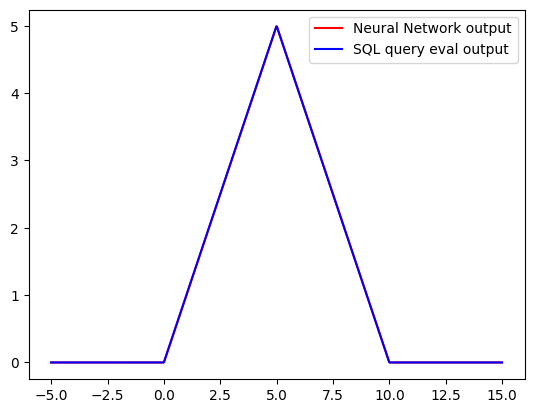

In [9]:
# Since we are evaluating a lot of points in 1 query, increase our limits
db.con.execute("SET max_expression_depth TO 1100")

with torch.no_grad():
    model.eval()
    y_model = model(torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)).detach().numpy()
y_sql = eval_nn(np.expand_dims(x_train, axis=1))

plt.plot(x_train, y_model, 'r', label='Neural Network output')
plt.plot(x_train, y_sql, 'b', label='SQL query eval output')
plt.legend()
plt.show()

As we can see, our methods still work, even though we started from an ONNX file.

## Conclusion

We can read all the weights and biases from an ONNX file, store these in a
database, and run our queries on them. There is no need for a hard dependency on
PyTorch.

We still need to work on generalizing the parsing of the ONNX file, since it
still relies on hardcoded assumptions.